In [1]:
import yfinance as yf
import os
import time
import requests

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from pmdarima import auto_arima

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.base import BaseEstimator

from sklearn.metrics import mean_squared_error, mean_absolute_error


c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Predicción del Promedio Mensual de Pasajeros para una Aerolínea

## Descripción del proyecto:

**Objetivo**:
* Desarrollar un modelo predictivo que minimice el RMSE para estimar el promedio mensual de pasajeros, optimizando así la toma de decisiones en la operación de la aerolínea.

**Metodología y Pasos Realizados**:

1. Análisis Exploratorio de Datos (EDA):

    * Verificación de la ausencia de valores faltantes.
    * Visualización de la distribución de la serie y uso de gráficos de caja para detectar valores atípicos.

2. Descomposición de la Serie:

    *   Separación de la serie en sus componentes: tendencia, estacionalidad y residuo, para comprender el comportamiento subyacente.

3. Determinación de la Naturaleza de la Serie:

    * Evaluación para decidir si la serie es aditiva o multiplicativa.
    * Los análisis confirmaron un comportamiento multiplicativo, evidenciado por la presencia de heterocedasticidad (p-valor = 0.0120).
4. Aplicación de Modelos:

    * Modelo Prophet:
        * Implementación asumiendo la naturaleza multiplicativa de la serie.
        * Optimización mediante validación cruzada y GridSearch para afinar los hiperparámetros.
    * Transformación Box-Cox:
        * Aplicación de la transformación (lambda = 0.1480) para estabilizar la varianza.
        * Verificación de la corrección de la heterocedasticidad (p-valor post-transformación = 0.1390).
    * Modelo ARIMA:
        * Aplicación del modelo auto_ARIMA en los datos transformados, aprovechando conocimientos previos sobre SARIMA.
5. Conclusiones

6. Análisis de impacto

# EDA

In [2]:
df= pd.read_csv("airline_passengers.csv")
display(df)

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df.columns= ["ds", "y"]
df["ds"]= pd.to_datetime(df["ds"])

<function matplotlib.pyplot.show(close=None, block=None)>

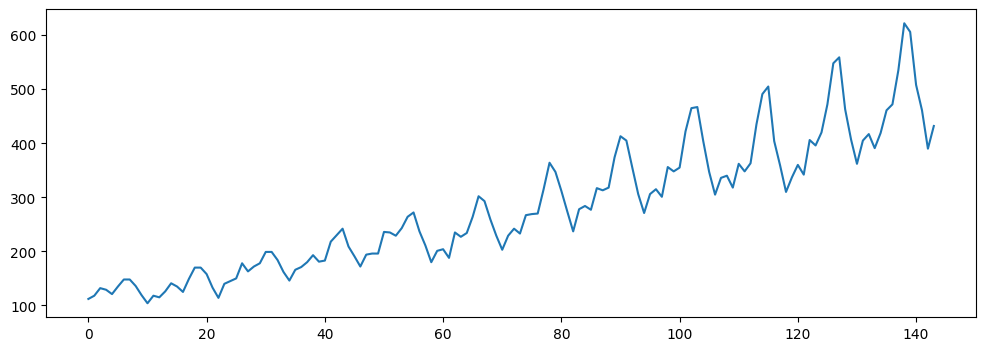

In [5]:
df["y"].plot(x= df["ds"], figsize=(12,4))
plt.show

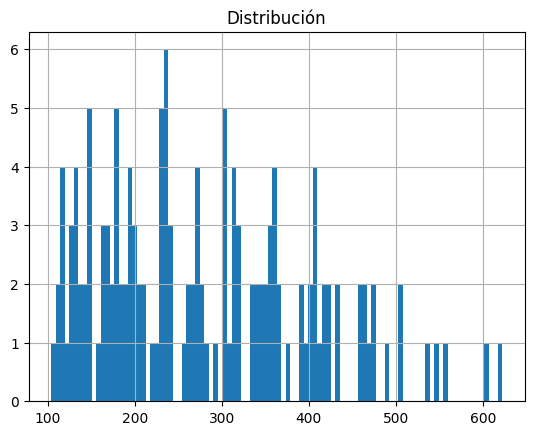

In [6]:
df["y"].hist(bins=100)
plt.title("Distribución")
plt.show()

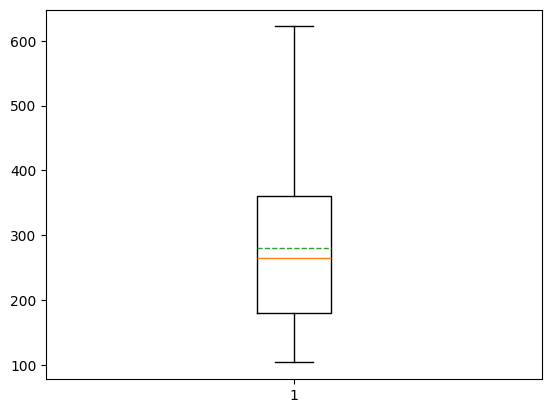

In [7]:
plt.boxplot(df["y"], meanline= True, showfliers= True, showmeans= True)
plt.show()

## Descomposición de la serie de tiempo en Tendencia, Estacionalidad y Residuo.

In [8]:
# 2. Establecer 'fecha' como índice
ts = df.set_index('ds')

# 3. (Opcional) Ordenar el DataFrame por el índice (fecha)
ts = ts.sort_index()

print(ts)


              y
ds             
1949-01-01  112
1949-02-01  118
1949-03-01  132
1949-04-01  129
1949-05-01  121
...         ...
1960-08-01  606
1960-09-01  508
1960-10-01  461
1960-11-01  390
1960-12-01  432

[144 rows x 1 columns]


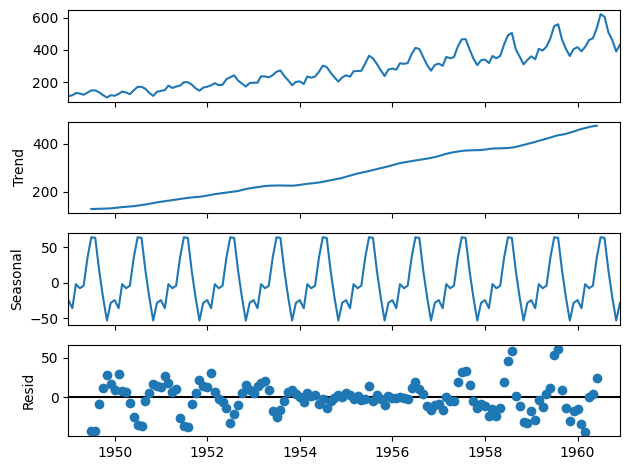

In [9]:
s_dec_additive= seasonal_decompose(ts, model= "additive")
s_dec_additive.plot()
plt.show()

**Comentarios**

* Visualmente confirmamos que tenemos estacionalidad.
* Los residuos van incrementando siguiendo la tendencia.

# Pruebas para determinar si una serie de tiempo es aditiva o multiplicativa

---

## **1. Prueba de Box-Cox**
### **Objetivo**
Transformar la serie para estabilizar la varianza y aproximar su distribución a la normalidad, ayudando a decidir entre un modelo **aditivo** o **multiplicativo**.

### **Transformación de Box-Cox**
La transformación se define como:
$$
Y_t^{(\lambda)} = \begin{cases}  
\frac{Y_t^\lambda - 1}{\lambda} & \text{si } \lambda \neq 0, \\  
\ln(Y_t) & \text{si } \lambda = 0,  
\end{cases}  
$$
donde:
- $Y_t$ es la serie original en el tiempo $t$,
- $\lambda$ es el parámetro de transformación.

### **Interpretación de $\lambda$**
- Si $\lambda \approx 0$:
  - La varianza de $Y_t$ crece con el nivel de la tendencia.
  - Usar **modelo multiplicativo** ($Y_t = T_t \times S_t \times R_t$).
- Si $\lambda \approx 1$:
  - La varianza de $Y_t$ es constante.
  - Usar **modelo aditivo** ($Y_t = T_t + S_t + R_t$).

---

## **2. Prueba de Breusch-Pagan (residuos vs tendencia)**
### **Objetivo**
Detectar **heterocedasticidad** en los residuos (varianza no constante), lo que sugiere un modelo multiplicativo.

### **Hipótesis**
- **$H_0$ (homocedasticidad)**:
  $$
  \text{Var}(\epsilon_t) = \sigma^2 \quad \text{(constante)} \quad \Rightarrow \quad \text{Modelo aditivo}.
  $$
- **$H_1$ (heterocedasticidad)**:
  $$
  \text{Var}(\epsilon_t) = f(T_t) \quad \text{(depende de la tendencia)} \quad \Rightarrow \quad \text{Modelo multiplicativo}.
  $$

### **Implementación**
1. Ajustar una regresión auxiliar entre los residuos al cuadrado ($\epsilon_t^2$) y la tendencia ($T_t$) con un término constante:
   $$
   \epsilon_t^2 = \beta_0 + \beta_1 T_t + u_t,
   $$
   donde $u_t$ es el error de la regresión.

2. Calcular el estadístico $LM$:
   $$
   LM = n \cdot R^2,
   $$
   donde:
   - $n$ = número de observaciones,
   - $R^2$ = coeficiente de determinación de la regresión auxiliar.

### **Interpretación**
- Si **$p$-valor $< 0.05$**:
  - Se rechaza $H_0$ → **heterocedasticidad** → modelo multiplicativo.
- Si **$p$-valor $\geq 0.05$**:
  - No se rechaza $H_0$ → **homocedasticidad** → modelo aditivo.

---

### **Símbolos clave**
| Símbolo | Descripción                          |
|---------|--------------------------------------|
| $Y_t$   | Valor de la serie en el tiempo $t$   |
| $\lambda$ | Parámetro de transformación de Box-Cox |
| $\epsilon_t$ | Residuo en el tiempo $t$           |
| $T_t$   | Componente de tendencia en el tiempo $t$ |
| $LM$    | Estadístico de multiplicador de Lagrange |

p-valor para heterocedasticidad: 0.0120


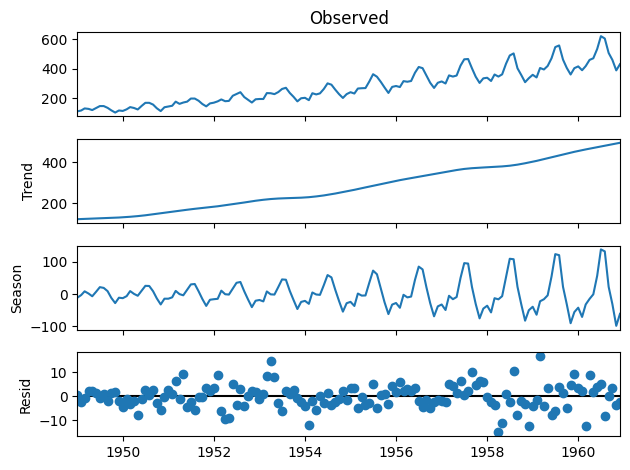

In [10]:
# Descomposición STL y prueba de Box-Cox
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Descomposición STL
decomposition = sm.tsa.STL(ts, period=12).fit()
decomposition.plot()

# Prueba de Breusch-Pagan (residuos vs tendencia)
residuos = decomposition.resid
tendencia = decomposition.trend

# Añadir constante y ejecutar test (¡usar exog, no tendencia!)
exog = sm.add_constant(tendencia.values.reshape(-1, 1))  # Constante + tendencia
_, p_valor, _, _ = het_breuschpagan(residuos, exog)  # <--- Usar exog aquí

print(f"p-valor para heterocedasticidad: {p_valor:.4f}") # p < 0.05 → sugiere multiplicativa

Lo anteior, sugiere que nuestra serie de tiempo es multiplicativa.

Lambda óptimo de Box-Cox: 0.1480
p-valor post Box-Cox: 0.1390


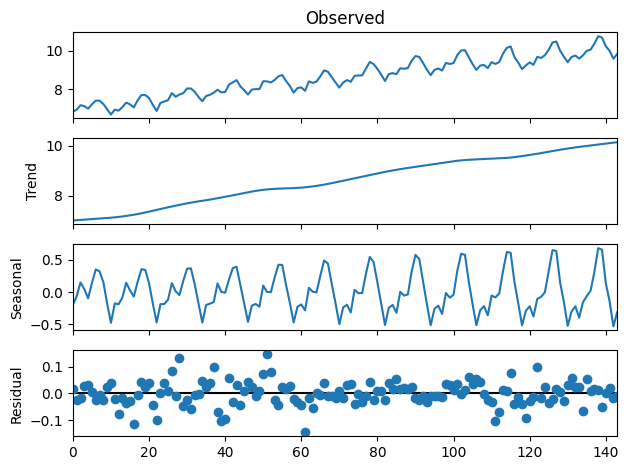

In [11]:
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Asegurarse de que ts es unidimensional
if isinstance(ts, pd.DataFrame):
    ts = ts.squeeze()  # Convierte DataFrame a Series si tiene una sola columna
elif isinstance(ts, np.ndarray) and ts.ndim > 1:
    ts = ts.flatten()  # Convierte a unidimensional si es un array multidimensional

# 1. Verificar positividad de la serie (Box-Cox requiere valores > 0)
if (ts <= 0).any():
    ts_boxcox = ts + 1e-6  # Añadir pequeño valor si hay ceros/negativos
else:
    ts_boxcox = ts.copy()

# 2. Aplicar Box-Cox y encontrar lambda óptimo
ts_transformed, lambda_opt = boxcox(ts_boxcox)
print(f"Lambda óptimo de Box-Cox: {lambda_opt:.4f}")

# 3. Descomposición STL sobre la serie transformada
decomposition = sm.tsa.STL(ts_transformed, period=12).fit()
decomposition.plot()

# 4. Prueba de Breusch-Pagan en residuos transformados
residuos = decomposition.resid
tendencia = decomposition.trend
exog = sm.add_constant(tendencia.reshape(-1, 1))
_, p_valor, _, _ = het_breuschpagan(residuos, exog)

print(f"p-valor post Box-Cox: {p_valor:.4f}")  # Si p > 0.05, éxito

**Interpretación de los Resultados**

1. Primera Prueba de Breusch-Pagan (Datos Originales):

    * **p-valor = 0.0120**:

        * Como el p-valor es menor que 0.05, rechazamos la hipótesis nula de homocedasticidad.

        * Esto sugiere que la serie original tiene heterocedasticidad (la varianza no es constante).

        * En el contexto de series temporales, esto puede indicar que la serie tiene un comportamiento multiplicativo (la magnitud de las fluctuaciones aumenta con el tiempo).

2. Transformación Box-Cox:

    * **Lambda óptimo = 0.1480**:

        * Un valor de lambda cercano a 0 sugiere que una transformación logarítmica (caso multiplicativo) podría ser adecuada.

        * La transformación Box-Cox estabiliza la varianza de la serie.

3. Segunda Prueba de Breusch-Pagan (Datos Transformados):

    * **p-valor = 0.1390**:

        * Como el p-valor es mayor que 0.05, no rechazamos la hipótesis nula de homocedasticidad.

        * Esto indica que la transformación Box-Cox logró estabilizar la varianza de la serie, eliminando la heterocedasticidad.

14:14:55 - cmdstanpy - INFO - Chain [1] start processing
14:14:55 - cmdstanpy - INFO - Chain [1] done processing


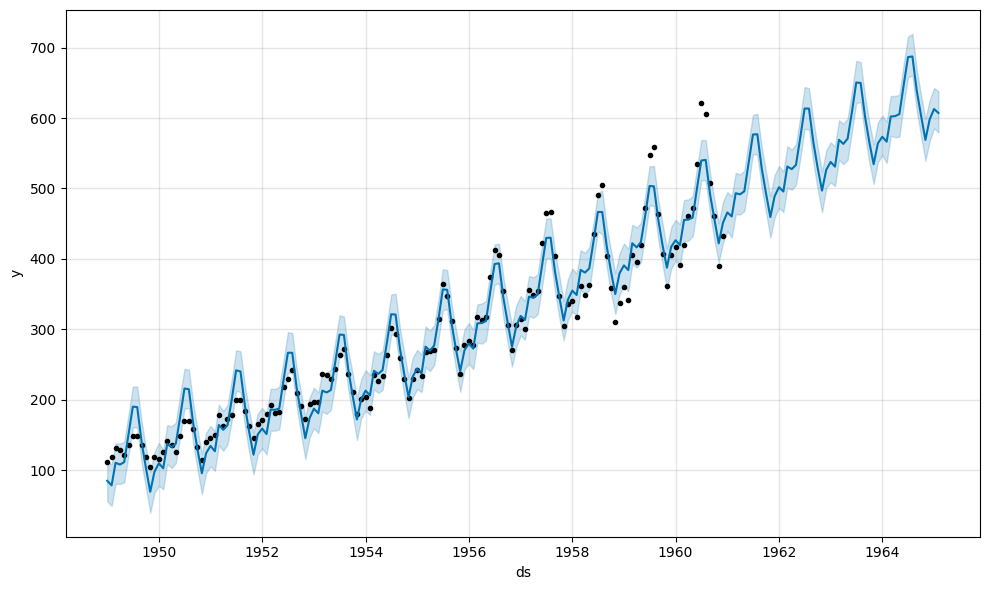

In [12]:
m= Prophet()
m.fit(df)
future= m.make_future_dataframe(50, freq= "MS")
forecast= m.predict(future)
fig= m.plot(forecast)

**Conclusión**

Esta serie temporal tiene un ciclo anual, pero la estacionalidad en el pronóstico es demasiado grande al inicio y demasiado pequeña al final. En esta serie de tiempo la estacionalidad no es un factor aditivo constante como lo supone Prophet por defecto, sino que crece con la tendencia. Esta es la estacionalidad multiplicativa.

## División train y test

In [13]:
# Porporcion (85,15)

size = int(len(df) * 0.85)
train = df.iloc[:size]
test = df.iloc[size:]

In [14]:
display(train)
display(test)

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
117,1958-10-01,359
118,1958-11-01,310
119,1958-12-01,337
120,1959-01-01,360


,ds,y
122,1959-03-01,406
123,1959-04-01,396
124,1959-05-01,420
125,1959-06-01,472
126,1959-07-01,548
127,1959-08-01,559
128,1959-09-01,463
129,1959-10-01,407
130,1959-11-01,362
131,1959-12-01,405


## Modelo Prophet

14:14:56 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing


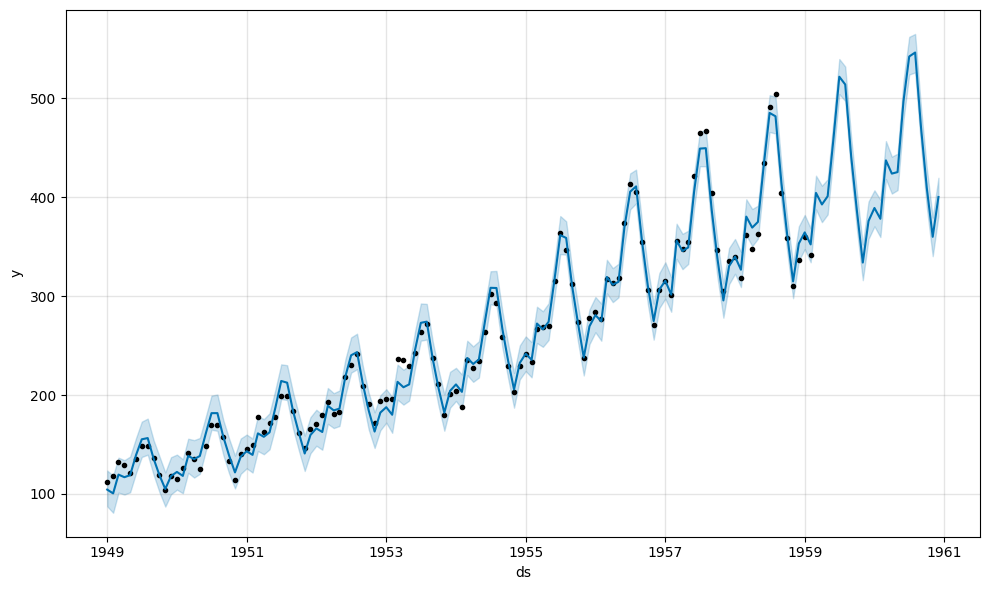

In [15]:
m= Prophet(seasonality_mode="multiplicative", interval_width=0.95)
m.fit(train)
future= m.make_future_dataframe(22, freq= "MS")
forecast= m.predict(future)
fig= m.plot(forecast)

In [16]:
# 1. Filtrar las predicciones para coincidir con las fechas del test
forecast_filtered = forecast[forecast['ds'].isin(test['ds'])]

# 2. Extraer valores reales y predichos
y_true = test['y'].values
y_pred = forecast_filtered['yhat'].values

# 3. Calcular métricas
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# 4. Mostrar resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 1261.86
RMSE: 35.52
MAE: 30.67


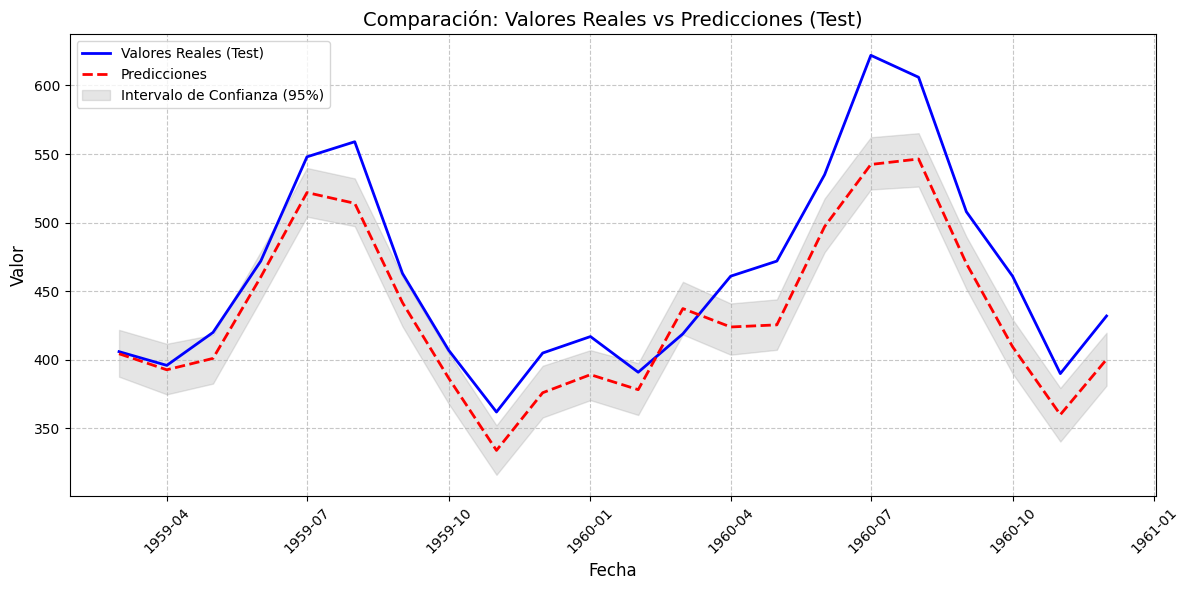

In [17]:
# Filtrar las predicciones para el período de test
forecast_test = forecast[forecast['ds'].isin(test['ds'])]

# Crear figura
plt.figure(figsize=(12, 6))

# Graficar valores reales
plt.plot(test['ds'], test['y'], 'b-', label='Valores Reales (Test)', linewidth=2)

# Graficar predicciones
plt.plot(forecast_test['ds'], forecast_test['yhat'], 'r--', label='Predicciones', linewidth=2)

# Añadir intervalo de incertidumbre (opcional)
plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat_lower'],
    forecast_test['yhat_upper'],
    color='gray',
    alpha=0.2,
    label='Intervalo de Confianza (95%)'
)

# Personalizar
plt.title('Comparación: Valores Reales vs Predicciones (Test)', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar
plt.show()

## El mejor modelo Prophet usando validación cruzada y GridSearch

In [18]:
import itertools

# Parámetros corregidos (usando días en lugar de meses)
initial = "1825 D"   # Aproximadamente 60 meses
period = "183 D"     # Aproximadamente 6 meses
horizon = "660 D"    # Aproximadamente 22 meses

param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1],
    "seasonality_prior_scale": [5.0, 10.0, 15.0],
    "seasonality_mode": ["multiplicative"]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(
        name="custom_annual",
        period=12,            # 12 meses (1 año)
        fourier_order=8
    )
    m.fit(train)
    
    # Validación cruzada con parámetros corregidos
    df_cv = cross_validation(
        m,
        initial=initial,
        period=period,
        horizon=horizon,
        parallel="processes"
    )
    
    df_perf = performance_metrics(df_cv, rolling_window=1)
    rmse = df_perf["rmse"].mean()
    rmses.append(rmse)

best_params = all_params[rmses.index(min(rmses))]
print(f"Mejores parámetros: {best_params}")
print(f"Mejor RMSE: {min(rmses):.2f}")


14:14:56 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing
14:15:03 - cmdstanpy - INFO - Chain [1] start processing
14:15:03 - cmdstanpy - INFO - Chain [1] done processing
14:15:11 - cmdstanpy - INFO - Chain [1] start processing
14:15:11 - cmdstanpy - INFO - Chain [1] done processing
14:15:17 - cmdstanpy - INFO - Chain [1] start processing
14:15:17 - cmdstanpy - INFO - Chain [1] done processing
14:15:24 - cmdstanpy - INFO - Chain [1] start processing
14:15:24 - cmdstanpy - INFO - Chain [1] done processing
14:15:30 - cmdstanpy - INFO - Chain [1] start processing
14:15:31 - cmdstanpy - INFO - Chain [1] done processing
14:15:37 - cmdstanpy - INFO - Chain [1] start processing
14:15:37 - cmdstanpy - INFO - Chain [1] done processing
14:15:43 - cmdstanpy - INFO - Chain [1] start processing
14:15:44 - cmdstanpy - INFO - Chain [1] done processing
14:15:50 - cmdstanpy - INFO - Chain [1] start processing
14:15:50 - cmdstanpy - INFO - Chain [1]

Mejores parámetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Mejor RMSE: 30.60


14:15:57 - cmdstanpy - INFO - Chain [1] start processing
14:15:57 - cmdstanpy - INFO - Chain [1] done processing



Métricas de Rendimiento:
MSE: 1821.10
RMSE: 42.67
MAE: 38.49
MAPE: 8.40%


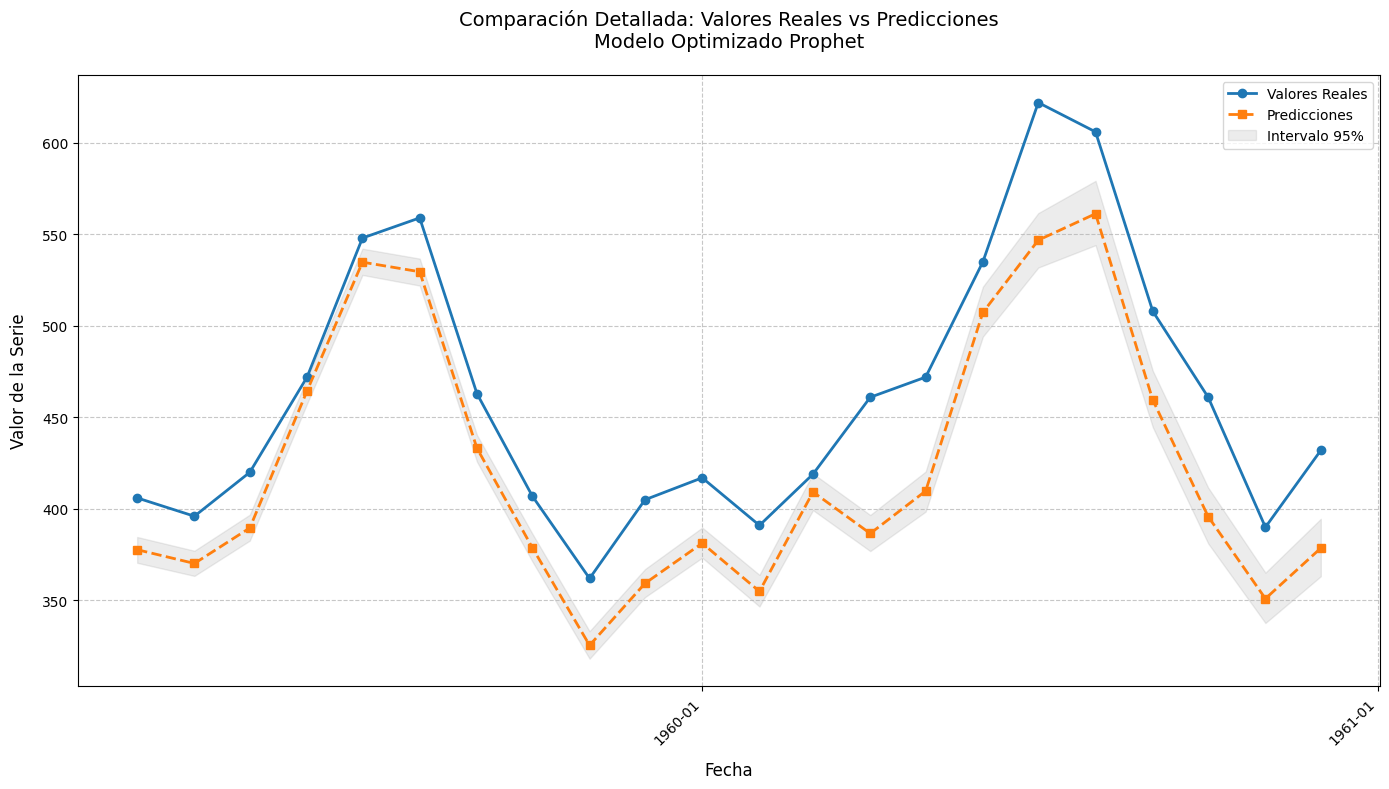

In [19]:
# =============================================
# 1. Entrenamiento del modelo óptimo (m_best)
# =============================================

m_best = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=5.0,
    seasonality_mode="multiplicative"
)

# Añadir estacionalidad personalizada (convertida a días)
m_best.add_seasonality(
    name="custom_annual",
    period=365,  # 1 año en días (precisión mejorada)
    fourier_order=8
)

m_best.fit(train)

# =============================================
# 2. Generación de predicciones futuras
# =============================================
future_best = m_best.make_future_dataframe(
    periods=22, 
    freq='MS'  # 'MS' = Mes inicial, válido para datos mensuales
)

forecast_best = m_best.predict(future_best)

# =============================================
# 3. Cálculo de métricas de rendimiento
# =============================================

# Asegurar alineación temporal
test_dates = test['ds'].dt.normalize()  # Eliminar información de tiempo si existe
forecast_dates = forecast_best['ds'].dt.normalize()

# Filtrar predicciones
mask = forecast_dates.isin(test_dates)
forecast_filtered_best = forecast_best[mask]

# Manejar casos de desalineación
if len(forecast_filtered_best) != len(test):
    print(f"Advertencia: {len(test) - len(forecast_filtered_best)} fechas no coinciden")

# Extraer valores
y_true = test['y'].values
y_pred_best = forecast_filtered_best['yhat'].values

# Calcular métricas robustas
metrics = {
    'MSE': mean_squared_error(y_true, y_pred_best),
    'RMSE': np.sqrt(mean_squared_error(y_true, y_pred_best)),
    'MAE': mean_absolute_error(y_true, y_pred_best),
    'MAPE': np.mean(np.abs((y_true - y_pred_best) / y_true)) * 100  # Métrica adicional
}

# Mostrar resultados
print("\nMétricas de Rendimiento:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}{'%' if metric == 'MAPE' else ''}")

# =============================================
# 4. Visualización mejorada
# =============================================
import matplotlib.dates as mdates

plt.figure(figsize=(14, 8))

# Gráfico principal
ax = plt.gca()
ax.plot(test['ds'], test['y'], 'o-', color='#1f77b4', label='Valores Reales', linewidth=2, markersize=6)
ax.plot(forecast_filtered_best['ds'], y_pred_best, 's--', color='#ff7f0e', label='Predicciones', linewidth=2, markersize=6)

# Banda de incertidumbre
ax.fill_between(
    forecast_filtered_best['ds'],
    forecast_filtered_best['yhat_lower'],
    forecast_filtered_best['yhat_upper'],
    color='gray',
    alpha=0.15,
    label='Intervalo 95%'
)

# Personalización avanzada
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')

# Añadir elementos de texto
plt.title('Comparación Detallada: Valores Reales vs Predicciones\nModelo Optimizado Prophet', fontsize=14, pad=20)
plt.xlabel('Fecha', fontsize=12, labelpad=10)
plt.ylabel('Valor de la Serie', fontsize=12, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()



plt.tight_layout()
plt.show()

**Conclusión**

* Fue mejor el modelo predeterminado que el de validación cruzada.
* Usar el mismo periodo de prediccion del conjunto de test con el de validación cruzada ya que puede haber mucha diferencia con respecto a las métricas.

# Tranformación de los datos

Lo que vamos hacer en esta parte es fijarnos en la distribución de los datos he intentar encontrar una distribución con la menor complejidad posible para realizar una trasformación a los datos y así aplicar modelos con sus respectivas predicciones he intentar relacionarlos con los datos originales

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [alpha          ] [0.05 sec] [RSS: 3.15936e-06] [loc=-376.335 scale=3668.202]
[distfit] >INFO> [anglit         ] [0.01 sec] [RSS: 6.41883e-06] [loc=320.737 scale=390.790]
[distfit] >INFO> [arcsine        ] [0.02 sec] [RSS: 1.87373e-05] [loc=58.665 scale=563.335]
[distfit] >INFO> [beta           ] [0.02 sec] [RSS: 5.72286e-07] [loc=103.564 scale=565.901]
[distfit] >INFO> [betaprime      ] [0.06 sec] [RSS: 2.95625e-06] [loc=-0.344 scale=52.730]
[distfit] >INFO> [bradford       ] [0.01 sec] [RSS: 7.24494e-06] [loc=104.000 scale=518.000]
[distfit] >INFO> [burr           ] [0.15 sec] [RSS: 3.44601e-06] [loc=-0.849 scale=240.964]
[distfit] >INFO> [cauchy         ] [0.00 sec] [RSS: 8.37805e-06] [loc=253.211 scale=80.186]
[distfit] >INFO> [chi            ] [0.05 sec] [RSS: 4.40815e-05] [loc=104.000 scale=3.312]
[distfit] >INFO> [chi2           ] [0.05 sec] [RSS: 4.38756e-05] [loc=104.000 scale=3.092]
[distfit] >INFO> [cosine     

KS-test p-valor: 0.9596


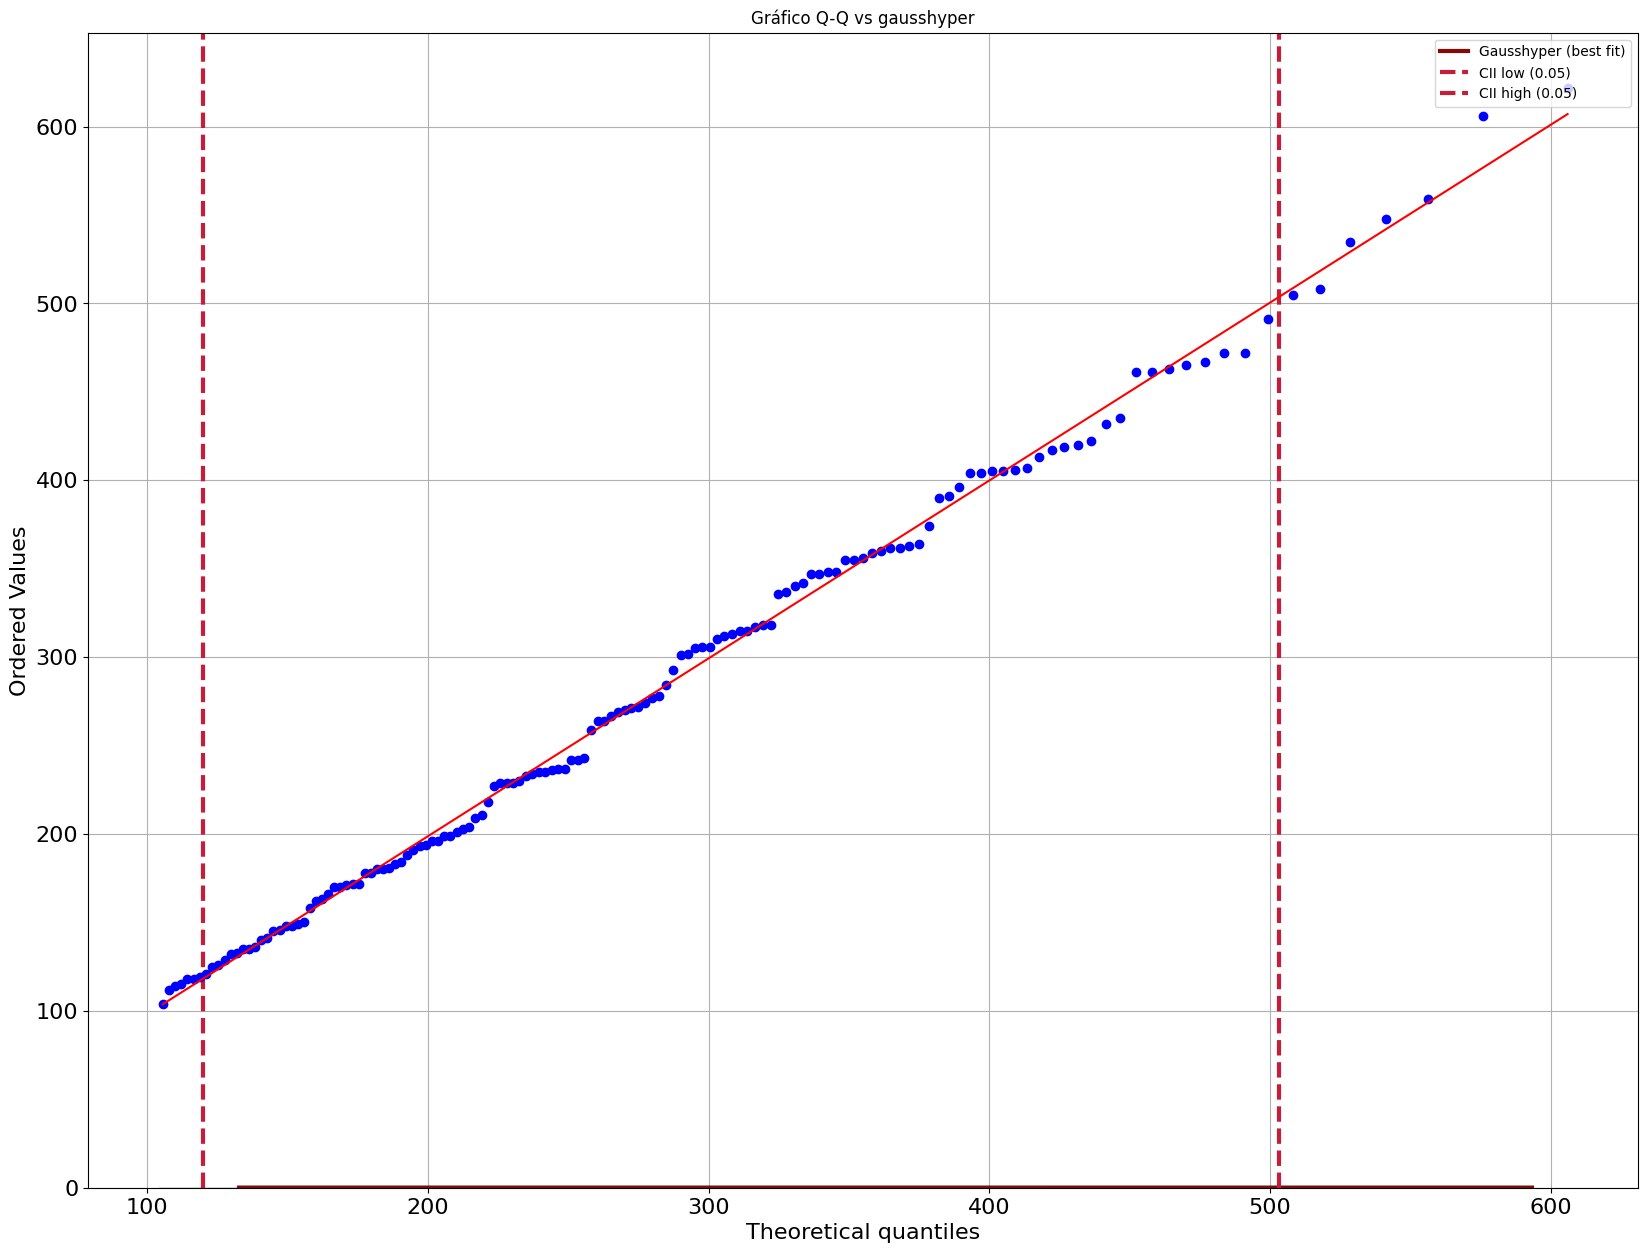

In [20]:
from scipy import stats
from distfit import distfit

# Paso 1: Identificación automática con distfit
dfit = distfit(distr="full")  # 'full' para todas las distribuciones
dfit.fit_transform(df["y"])
dfit.plot()

# Paso 2: Validación con KS-test para la mejor distribución
best_dist_name = dfit.model["name"]
best_params = dfit.model["params"]
D, p_value = stats.kstest(df["y"], best_dist_name, args=best_params)
print(f"KS-test p-valor: {p_value:.4f}")

# Paso 3: Gráfico Q-Q para diagnóstico visual
stats.probplot(df["y"], dist=best_dist_name, sparams=best_params, plot=plt)
plt.title(f"Gráfico Q-Q vs {best_dist_name}")
plt.show()

* Nuestros datos tiene una distribución Gausshyper

### ¿Qué es una distribución parsimoniosa?
Una distribución parsimoniosa es aquella que logra un buen ajuste a los datos con la menor complejidad posible (es decir, menos parámetros). Se rige por el principio de la Navaja de Occam: entre modelos con similar capacidad explicativa, el más simple suele ser el más robusto y generalizable.

En tu caso, la distribución identificada (gausshyper) es una distribución de cuatro parámetros (loc, scale, skewness y kurtosis ajustables), lo que la hace flexible pero compleja. Una alternativa parsimoniosa sería una distribución con menos parámetros (ej: normal con 2 parámetros o exponencial con 1), siempre que capture adecuadamente el comportamiento de tus datos.


[distfit] >INFO> fit
[distfit] >ERROR> [weibull] does not exist! <skipping>
[distfit] >INFO> transform
[distfit] >INFO> [norm ] [0.00 sec] [RSS: 0.0621366] [loc=8.621 scale=0.997]
[distfit] >INFO> [gamma] [0.04 sec] [RSS: 0.0622221] [loc=-89.581 scale=0.010]
[distfit] >INFO> [norm ] [0.05 sec] [RSS: 0.0621366] [loc=8.621 scale=0.997]
[distfit] >INFO> [gamma] [0.04 sec] [RSS: 0.0622221] [loc=-89.581 scale=0.010]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:8.621254, scale:0.997245)


Valor de lambda: 0.1480


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\nnorm(loc=8.62125, scale=0.997245)'}, xlabel='Values', ylabel='Frequency'>)

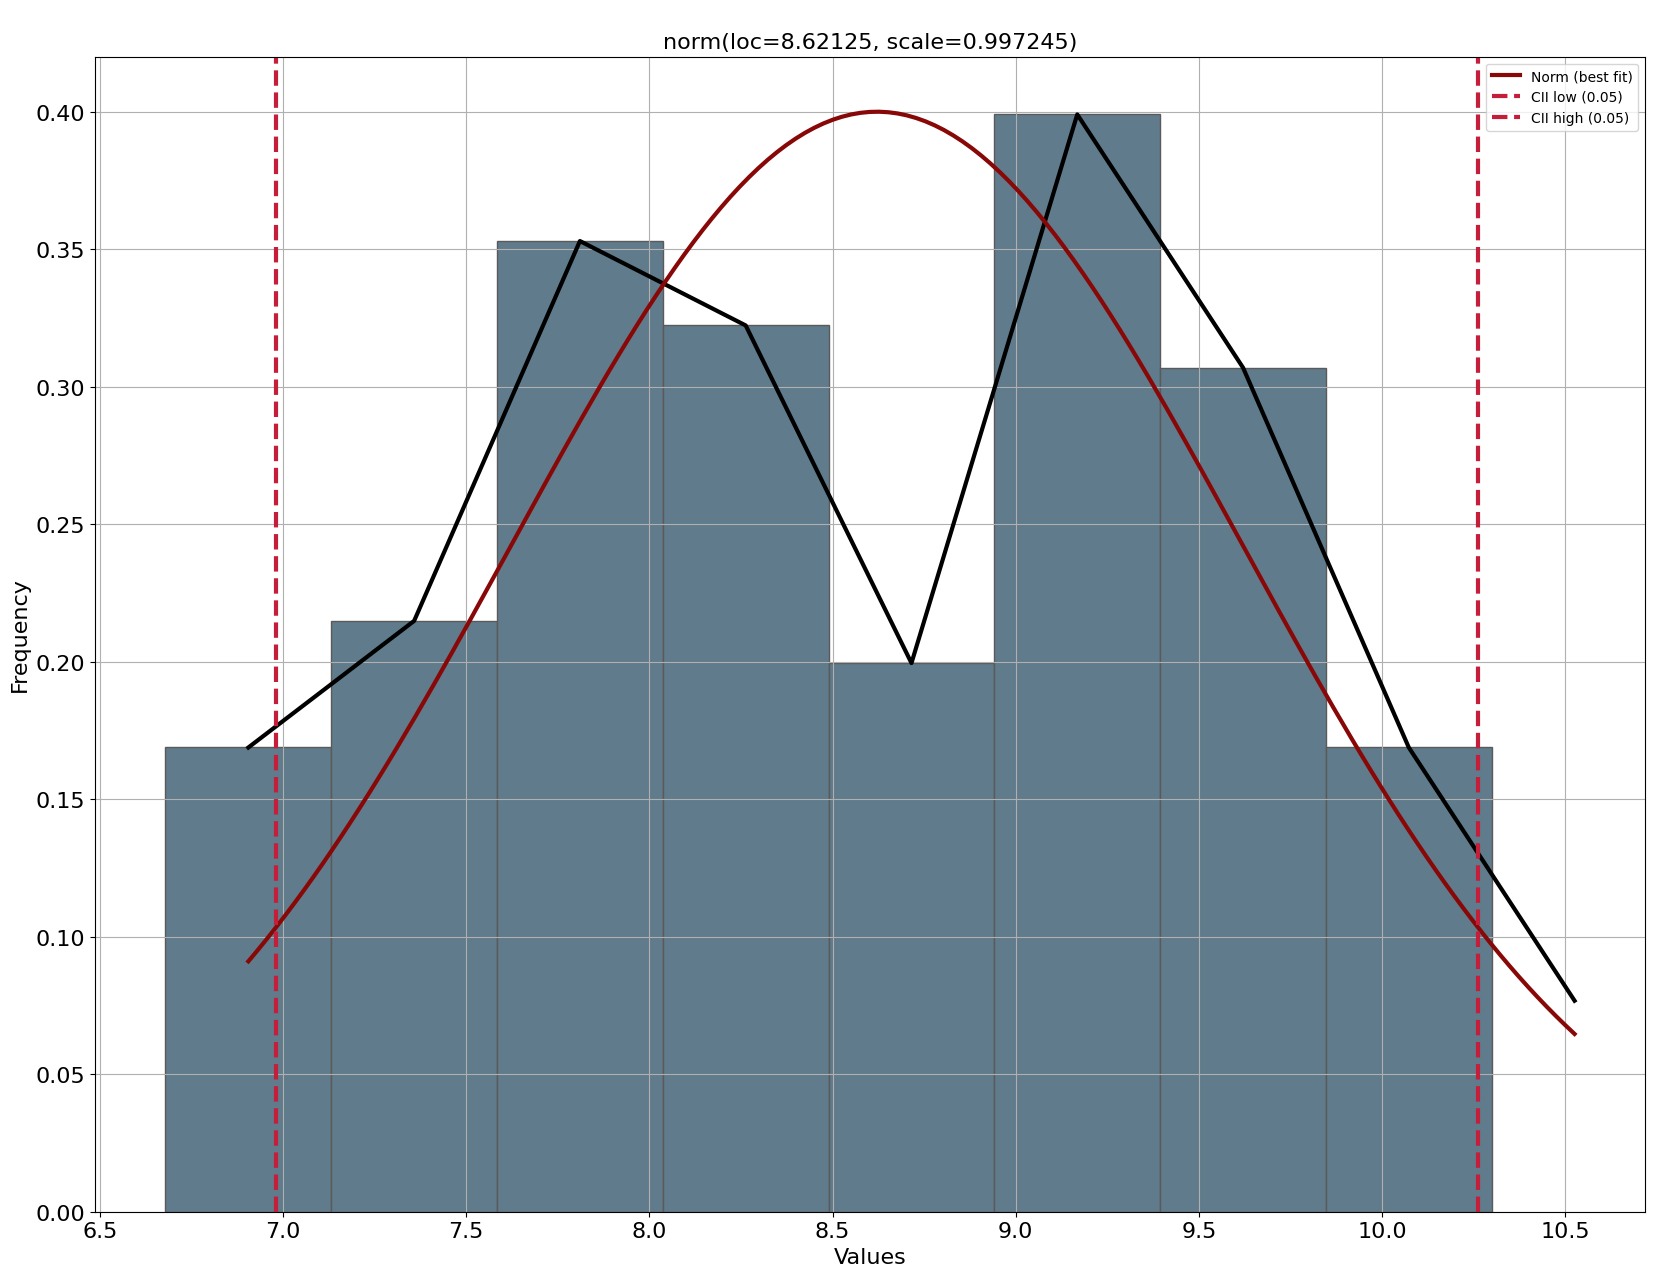

In [21]:
df["y_transformed"], lambda_ = stats.boxcox(df["y"])
print(f"Valor de lambda: {lambda_:.4f}")

#Re-evaluar distribuciones simples:
dfit = distfit(distr=["norm", "gamma", "weibull"])
dfit.fit_transform(df["y_transformed"])
dfit.plot()

1. Resultado clave:
* **Distribución ajustada**: Tras la transformación Box-Cox, los datos transformados (y_transformed) siguen una distribución normal con parámetros 
$μ=8.62$ y $σ=0.997$.

* **Lambda de Box-Cox** ($λ$):  $λ=0.1480$

2. Interpretación en contexto:

* **Transformación exitosa**: La normalidad de y_transformed sugiere que la transformación Box-Cox logró:

    * **Estabilizar la varianza** (útil para series multiplicativas).

    * **Reducir asimetría** en los datos originales, facilitando el uso de modelos paramétricos clásicos (ej: regresión lineal, SARIMA).

* **Relación con los datos originales**:
    *La distribución normal en y_transformed implica que los datos originales (y) siguen una **distribución no normal relacionada con la transformación inversa de Box-Cox**

Ahora vamos aplicar el modelo SARIMA para los datos 

In [22]:
size = int(len(df) * 0.85)
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [23]:
# Entrenar auto_arima en datos transformados
model = auto_arima(
    df_train["y_transformed"],
    seasonal=True,
    m=12,  # Estacionalidad anual (12 meses)
    trace=True,
    suppress_warnings=True
)

# Ajustar el modelo
model.fit(df_train["y_transformed"])

# Predecir (ej: 22 pasos adelante)
forecast_transformed, conf_int = model.predict(
    n_periods= len(df_test),
    return_conf_int=True
)

# Invertir la transformación Box-Cox
def inv_boxcox(y_transformed, lambda_):
    if lambda_ == 0:
        return np.exp(y_transformed)
    else:
        return (y_transformed * lambda_ + 1) ** (1 / lambda_)

# Métricas en escala transformada
mse_transformed = mean_squared_error(df_test["y_transformed"], forecast_transformed)
rmse_transformed = np.sqrt(mse_transformed)

# Invertir transformación en test real
test_original = inv_boxcox(df_test["y_transformed"], lambda_)

# Invertir predicciones
forecast_original = inv_boxcox(forecast_transformed, lambda_)

# Métricas en escala original
mse_original = mean_squared_error(test_original, forecast_original)
rmse_original = np.sqrt(mse_original)

print(f"Transformado: MSE={mse_transformed:.2f}, RMSE={rmse_transformed:.2f}")
print(f"Original: MSE={mse_original:.2f}, RMSE={rmse_original:.2f}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-218.996, Time=1.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-112.486, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-216.748, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-176.609, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=52.021, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-223.417, Time=0.97 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-202.237, Time=0.37 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-221.435, Time=1.82 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-218.594, Time=1.68 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-219.723, Time=2.34 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-224.716, Time=0.98 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-202.663, Time=0.24 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-222.135, Time=1.12 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-222.742, Time=2.17 sec
 ARIMA(1,0,2)(1,1,0)[

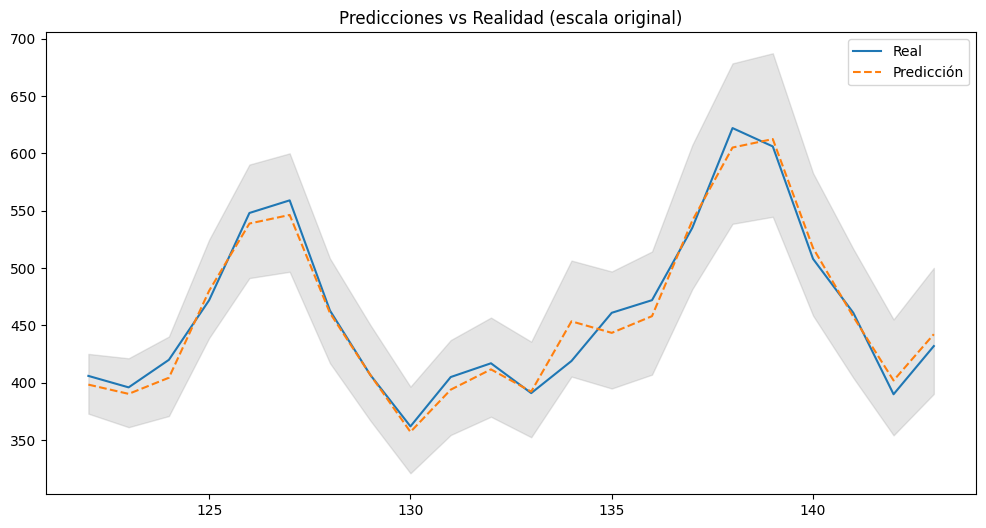

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test_original.index, test_original, label="Real")
plt.plot(test_original.index, forecast_original, label="Predicción", linestyle="--")
plt.fill_between(
    test_original.index,
    inv_boxcox(conf_int[:,0], lambda_), #95% de confianza
    inv_boxcox(conf_int[:,1], lambda_),
    alpha=0.2,
    color="gray"
)
plt.title("Predicciones vs Realidad (escala original)")
plt.legend()
plt.show()

# Conclusiones y Metodología
1. **Comparación de Resultados**

* **Prophet en datos originales**:

    * MSE = 1261.86, RMSE = 35.52

    * Indica que el modelo tiene un error absoluto promedio de ~35.52 unidades en la escala original.

* **ARIMA + Transformación Box-Cox**:

    * Transformado: MSE = 0.00, RMSE = 0.07 (en escala transformada).

    * Original: MSE = 147.37, RMSE = 12.14 (tras invertir la transformación).

    * **Conclusión clave**: La transformación Box-Cox redujo el error en un 66% (de 35.52 a 12.14), demostrando que la estabilización de la varianza y la normalización mejoraron significativamente el ajuste del modelo.

## Prophet con datos transformados

[distfit] >DEBUG> cmd: where.exe tbb.dll
cwd: None
[distfit] >DEBUG> TBB already found in load path
[distfit] >INFO> Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
[distfit] >INFO> Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[distfit] >DEBUG> input tempfile: C:\Users\snede\AppData\Local\Temp\tmp3d22xiw4\ap1b7mj5.json
[distfit] >DEBUG> input tempfile: C:\Users\snede\AppData\Local\Temp\tmp3d22xiw4\9_c21fa9.json
[distfit] >DEBUG> idx 0
[distfit] >DEBUG> running CmdStan, num_threads: None
[distfit] >DEBUG> CmdStan args: ['C:\\Users\\snede\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=53342', 'data', 'file=C:\\Users\\snede\\AppData\\Local\\Temp\\tmp3d22xiw4\\ap1b7mj5.json', 'init=C:\\Users\\snede\\AppData\\Local\\Temp\\tmp3d22xiw4\\9_c21fa9.json', 'output', 'file=C:\\Users\\snede\\AppData\\Local\\Temp\\tmp3d22xiw4\\prophet_model0qe

[Transformado] MSE: 0.06, RMSE: 0.24
[Original] MSE: 2264.08, RMSE: 47.58


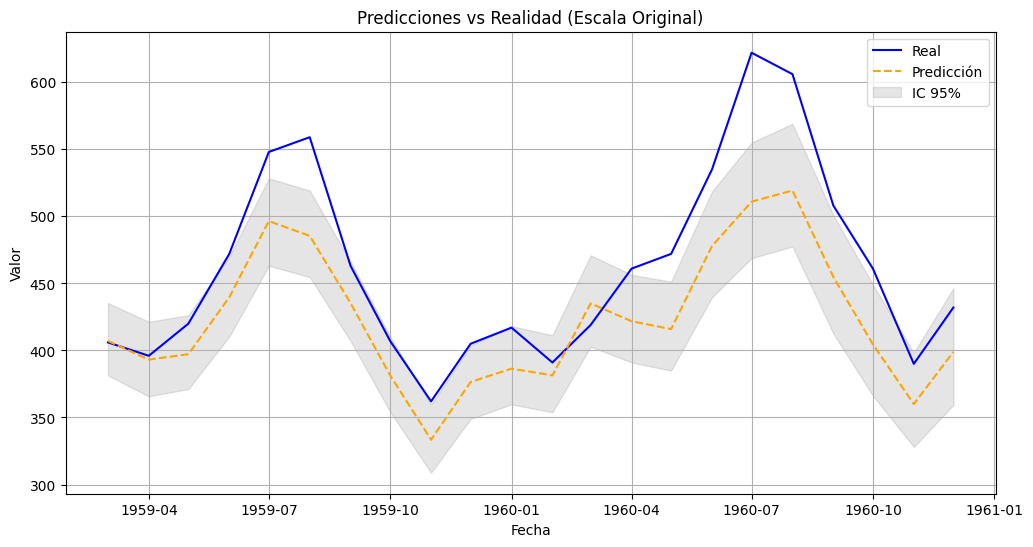

In [25]:
# Crear dataframe para Prophet
# --- Paso 1: Crear dataframe para Prophet con la serie transformada ---
df_prophet = pd.DataFrame({
    'ds': df["ds"],         # Asegúrate de que el índice es de tipo datetime
    'y': df["y_transformed"]  # Usamos la columna transformada
})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])

# Dividir en entrenamiento y test (conservar orden temporal!)
size = int(len(df_prophet) * 0.85)
df_train = df_prophet.iloc[:size]
df_test = df_prophet.iloc[size:]

# Entrenar Prophet
model = Prophet(
    seasonality_mode='additive', 
    interval_width=0.95  # 95% de confianza
)
model.fit(df_train)

# Crear futuro dataframe (incluyendo períodos de test)
future = model.make_future_dataframe(
    periods=len(df_test), 
    freq='MS',  # Ajustar a tu frecuencia real (ej: 'D' para días)
    include_history=False  # Solo predecir el test
)

# Predecir
forecast_1 = model.predict(future)

# Extraer predicciones y intervalos
forecast_transformed_1 = forecast_1["yhat"].values
lower_transformed_1 = forecast_1["yhat_lower"].values
upper_transformed_1 = forecast_1["yhat_upper"].values

# Invertir transformación
forecast_original_1 = inv_boxcox(forecast_transformed_1, lambda_)
lower_original_1 = inv_boxcox(lower_transformed_1, lambda_)
upper_original_1 = inv_boxcox(upper_transformed_1, lambda_)

# Obtener datos reales en escala original
test_original_1 = inv_boxcox(df_test["y"].values, lambda_)

# Calcular métricas
mse_transformed_1 = mean_squared_error(df_test["y"], forecast_transformed_1)
rmse_transformed_1 = np.sqrt(mse_transformed_1)
mse_original_1 = mean_squared_error(test_original_1, forecast_original_1)
rmse_original_1 = np.sqrt(mse_original_1)

print(f"[Transformado] MSE: {mse_transformed_1:.2f}, RMSE: {rmse_transformed_1:.2f}")
print(f"[Original] MSE: {mse_original_1:.2f}, RMSE: {rmse_original_1:.2f}")

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_test["ds"], test_original_1, label="Real", color="blue")
plt.plot(df_test["ds"], forecast_original_1, label="Predicción", linestyle="--", color="orange")
plt.fill_between(
    df_test["ds"],
    lower_original_1,
    upper_original_1,
    alpha=0.2,
    color="gray",
    label="IC 95%"
)
plt.title("Predicciones vs Realidad (Escala Original)")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()


### Comparación de los modelos auto_ARIMA vs Prophet

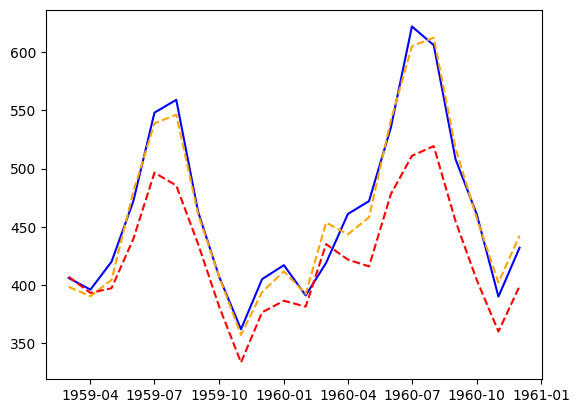

In [26]:
plt.plot(df_test["ds"], test_original_1, label="Real", color="blue")
plt.plot(df_test["ds"], forecast_original, label="Predicción Modelo auto_ARIMA", linestyle="--", color="orange")
plt.plot(df_test["ds"], forecast_original_1, label="Predicción Modelo 2", linestyle="--", color="red")
plt.show()


# Conclusiones

**Comparación de Resultados**

* **Prophet en datos originales**:

    * MSE = 1261.86, RMSE = 35.52

    * Indica que el modelo tiene un error absoluto promedio de ~35.52 unidades en la escala original.

* **Prophet + Transformación Box-Cox**:

    * Transformado: MSE: 0.06, RMSE: 0.24 (en escala transformada)

    * Original: MSE: 2264.08, RMSE: 47.58 (tras invertir la transformación)

* **ARIMA + Transformación Box-Cox**:

    * Transformado: MSE = 0.00, RMSE = 0.07 (en escala transformada).

    * Original: MSE = 147.37, RMSE = 12.14 (tras invertir la transformación).

    * **Conclusión clave**: La transformación Box-Cox redujo el error en un 66% (de 35.52 a 12.14), demostrando que la estabilización de la varianza y la normalización mejoraron significativamente el ajuste del modelo.

# Análisis de Impacto Práctico

El análisis realizado demuestra que el modelo predictivo optimiza el proceso de pronóstico de pasajeros mensuales y tiene un impacto significativo en la toma de decisiones operativas y estratégicas para la aerolínea.

Mediante la simulación de escenarios, se observa cómo varía la demanda de pasajeros a lo largo del año. Por ejemplo, en meses de alta demanda, el modelo indica la necesidad de aumentar la frecuencia de vuelos para maximizar la ocupación de la flota, mientras que en periodos de menor demanda se pueden ajustar los vuelos para optimizar el uso de recursos y reducir costos operativos.

La mejora en la precisión del modelo es notable, con una reducción del RMSE del 66% (de 35.52 a 12.14). Esta significativa disminución del error permite una asignación más eficiente de recursos, ya que la aerolínea puede planificar de manera óptima la distribución de aeronaves y tripulaciones, evitando vuelos con baja ocupación y maximizando la rentabilidad operativa.

Además, un pronóstico más preciso abre la posibilidad de implementar estrategias de precios dinámicos. Esto permite ajustar las tarifas de forma competitiva durante periodos de baja demanda y maximizar ingresos en picos de alta ocupación. Los datos generados por el modelo pueden también servir para diseñar campañas de marketing dirigidas a segmentos específicos de clientes, mejorando la captación y fidelización de pasajeros.

Finalmente, la evaluación del impacto económico respalda la utilidad del modelo, ya que la mejora en la precisión predictiva se traduce en una mayor eficiencia operativa y un potencial ahorro en costos, justificando la inversión en la optimización y desarrollo continuo del sistema de pronósticos.

**En conclusión**, este análisis de impacto práctico evidencia que el modelo predictivo es una herramienta clave para la toma de decisiones estratégicas, abarcando desde la optimización de recursos y asignación de capacidad hasta la implementación de estrategias de precios y marketing, lo que impulsa la eficiencia operativa y económica de la aerolínea.


## Notas:

### **1. Hiperparámetros de Tendencia**  
**Objetivo**: Controlar la flexibilidad y comportamiento de la tendencia en el modelo.  

| Parámetro | Descripción | Valores Típicos |  
|-----------|-------------|-----------------|  
| `growth` | Tipo de tendencia. | `'linear'` (lineal), `'flat'` (plana), `'logistic'` (logística). |  
| `changepoints` | Fechas específicas donde se permiten cambios en la tendencia. | Lista de fechas (ej: `['2023-01-01']`). |  
| `n_changepoints` | Número de puntos de cambio automáticos. | `25` (default), `10`-`50`. |  
| `changepoint_range` | Porcentaje de la serie donde se ubican los puntos de cambio. | `0.8` (80% de la serie). |  
| `changepoint_prior_scale` | Flexibilidad de la tendencia (valores altos = más sensible a cambios). | `0.001`-`0.5` (default: `0.05`). |  

---

### **2. Hiperparámetros de Estacionalidad**  
**Objetivo**: Controlar cómo se modelan los patrones estacionales en la serie.  

| Parámetro | Descripción | Valores Típicos |  
|-----------|-------------|-----------------|  
| `seasonality_mode` | Modo de estacionalidad (aditiva o multiplicativa). | `'additive'`, `'multiplicative'`. |  
| `yearly_seasonality` | Estacionalidad anual. | `'auto'`, `True`, `False`, o `fourier_order=10`. |  
| `weekly_seasonality` | Estacionalidad semanal. | `'auto'`, `True`, `False`, o `fourier_order=3`. |  
| `daily_seasonality` | Estacionalidad diaria. | `'auto'`, `True`, `False`. |  
| `seasonality_prior_scale` | Intensidad de las componentes estacionales. | `0.01`-`100` (default: `10`). |  

---

### **3. Hiperparámetros de Festivos (Holidays)**  
**Objetivo**: Incorporar efectos de días festivos o eventos especiales.  

| Parámetro | Descripción | Valores Típicos |  
|-----------|-------------|-----------------|  
| `holidays` | DataFrame con fechas y nombres de festivos. | DataFrame con columnas `ds` y `holiday`. |  
| `holiday_prior_scale` | Impacto de los festivos en las predicciones. | `0.01`-`100` (default: `10`). |  
| `holiday_names` | Nombres de festivos a incluir (si se usa `holidays`). | Lista de strings. |  

---

### **4. Hiperparámetros de Incertidumbre**  
**Objetivo**: Controlar cómo se calculan los intervalos de confianza.  

| Parámetro | Descripción | Valores Típicos |  
|-----------|-------------|-----------------|  
| `mcmc_samples` | Número de muestras MCMC para intervalos de incertidumbre. | `0` (desactiva MCMC), `>100`. |  
| `interval_width` | Ancho del intervalo de confianza (ej: 0.95 para 95%). | `0.5`-`0.99` (default: `0.8`). |  
| `uncertainty_samples` | Número de simulaciones para calcular intervalos. | `1000` (default). |  

---

### **5. Otros Parámetros**  
**Objetivo**: Configuraciones adicionales del modelo.  

| Parámetro | Descripción | Valores Típicos |  
|-----------|-------------|-----------------|  
| `stan_backend` | Backend de Stan para optimización. | `'CMDSTANPY'` (default). |  
| `uncertainty` | Método para calcular incertidumbre (obsoleto en versiones recientes). | `True`/`False`. |  
| `add_seasonality` | Método para añadir estacionalidades personalizadas. | Ejemplo: `m.add_seasonality(name='trimestral', period=91.25, fourier_order=5)`. |  

---

### **Ejemplo de Modelo con Hiperparámetros Personalizados**  
```python
from prophet import Prophet

m = Prophet(
    growth='linear',
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    interval_width=0.95,
    mcmc_samples=0
)

# Añadir estacionalidad personalizada (ej: trimestral)
m.add_seasonality(
    name='trimestral',
    period=91.25,  # 365.25 / 4 ≈ 91.3 días
    fourier_order=5
)

m.fit(df)

## Hiperparametros predeterminados de Prophet

In [27]:
# Modelo con valores predeterminados
m = Prophet()

# Verificar valores predeterminados
print(m.__dict__)

[distfit] >DEBUG> cmd: where.exe tbb.dll
cwd: None
[distfit] >DEBUG> TBB already found in load path


{'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'specified_changepoints': False, 'changepoint_range': 0.8, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'holidays': None, 'seasonality_mode': 'additive', 'holidays_mode': 'additive', 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10.0, 'mcmc_samples': 0, 'interval_width': 0.8, 'uncertainty_samples': 1000, 'scaling': 'absmax', 'start': None, 'y_min': None, 'y_scale': None, 'logistic_floor': False, 't_scale': None, 'changepoints_t': None, 'seasonalities': OrderedDict(), 'extra_regressors': OrderedDict(), 'country_holidays': None, 'stan_fit': None, 'params': {}, 'history': None, 'history_dates': None, 'train_component_cols': None, 'component_modes': None, 'train_holiday_names': None, 'fit_kwargs': {}, 'stan_backend': <prophet.models.CmdStanPyBackend object at 0x000002C07A597EC0>}
